In [1]:
import psycopg2
import itertools
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect(database="demo", user="postgres", password="1068", host="localhost", port="5432")
cur = conn.cursor()

In [3]:
num_types = 5
step_size = 0.02
min_area = 0.0004
max_area = 0.02
min_side = 0.02
thresh = 0.15
d = 500
data_path = 'large.txt'

In [4]:
def visualize_data(lst_of_points):
    
    ch = 'A'
    char_set = []
    n = len(lst_of_points)
    
    for i in range(n):
        char_set.append(ch)
        ch = chr(ord(ch) + 1)
    
    for i in range(n):
        lst = lst_of_points[i]
        lst = np.array(lst)
        lst = np.float64(lst)
        
        x = lst[:,0]
        y = lst[:,1]
        plt.scatter(x,y)
    plt.legend(char_set, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

In [5]:
def delete_tables():
    ch = 'A'
    char_set = []
    
    for i in range(num_types):
        char_set.append(ch)
        ch = chr(ord(ch) + 1)
    
#     char_set = ['A','B','C','D','E','F']
    
    for ch in char_set:
        query = '''Drop table if exists ''' + str(ch)
        cur.execute(query)
        conn.commit()
    

In [6]:
def insert_into_table():
    event = 'A'
    events = {}
    lst_of_points = []
    # file = open("data1.txt")
    with open(data_path) as file:
        while True:
            line = file.readline()
            if not line:
                break
            n = int(line)
            lst = []
            events[event] = n
            create_script = ' CREATE TABLE IF NOT EXISTS ' + event + ' (id SERIAL PRIMARY KEY,' + event + '_name VARCHAR(64),' + event + '_location GEOGRAPHY(POINT, 4326) )'
            cur.execute(create_script)

            for i in range(n):
                line = file.readline()
                name = event + str(i+1)
                lst.append((line.strip().split(" ",1)))

                point = "POINT(" + line.strip() + ")"


                insert_script = 'INSERT INTO ' + event + '(' + event + '_name, ' + event + '_location) VALUES(%s, %s)'
                insert_value = (name, point)
                cur.execute(insert_script, insert_value)
                conn.commit()
                
            lst_of_points.append(lst)    

            event = chr(ord(event)+1)

        file.close()

    return events, lst_of_points


In [7]:
delete_tables()
events, lst_of_points = insert_into_table()

In [8]:
events, len(lst_of_points)

({'A': 20, 'B': 21, 'C': 18, 'D': 17}, 4)

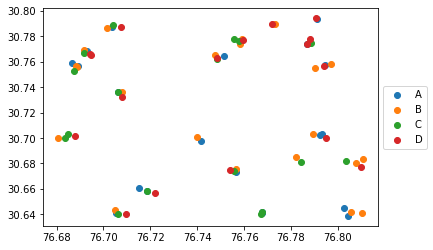

In [9]:
visualize_data(lst_of_points)

In [10]:
n = len(lst_of_points)
x_min, y_min, x_max, y_max = 10000, 10000, -1 , -1

for i in range(n):
    lst = lst_of_points[i]
    lst = np.array(lst)
    lst = np.float64(lst)
    
    mini = min(lst[:,0])
    if mini < x_min:
        x_min = mini
    mini = min(lst[:,1])
    if mini < y_min:
        y_min = mini
    
    maxi = max(lst[:,0])
    if maxi > x_max:
        x_max = maxi
    maxi = max(lst[:,1])
    if maxi > y_max:
        y_max = maxi        

In [11]:
print(f"(x_min = {x_min}, y_min = {y_min}), (x_max = {x_max}, y_max = {y_max})")
print(str((x_max-x_min)*(y_max-y_min)))

(x_min = 76.68069457895719, y_min = 30.638770989969345), (x_max = 76.81050952337735, y_max = 30.79404186093205)
0.02015647948409374


In [12]:
def find_points_inside_rec(x1, y1, x2, y2):
    result = []
    event_pre_in_rec = []
    for key in events.keys():
        select_query = (" select * from " +  str(key) + 
                        " where ST_Contains(ST_MakeEnvelope(" + 
                        str(x1) + "," +
                        str(y1) + "," +
                        str(x2) + "," +
                        str(y2) + "," +
                        str(4326) +
                        ")," + str(key) + "." + str(key) + "_location::geometry)") 
                                      
        cur.execute(select_query)
        temp = cur.fetchall()
        
        deleteQuery = '''Drop table if exists ''' + key + '_rec'
        cur.execute(deleteQuery)
        conn.commit()
        
        create_query = 'create table ' + key + '_rec as ' + select_query
        cur.execute(create_query)
       
        
        if len(temp) != 0:
            event_pre_in_rec.append(key)
            result += temp
        
    
    return result, event_pre_in_rec
       
        

In [13]:
def generate_pattern(event_pre_in_rec, k):
    return list(itertools.combinations(event_pre_in_rec, k))   

In [14]:
def cross_k_function_for_size_2(key, sub, d):   
    query = 'SELECT x.' + sub[0] + '_name, y.' + sub[1] + '_name FROM ' + sub[0] + '_rec' + ' as x JOIN ' + sub[1] + '_rec' + \
            ' as y ON ST_DWithin(x.' + sub[0] + '_location::geography, y.' + sub[1] + '_location::geography,' + str(d) + ')'
    cur.execute(query)
    result = cur.fetchall()

    deleteQuery = '''Drop table if exists ''' + key
    cur.execute(deleteQuery)
    conn.commit()

    createQuery = 'create table ' + key + ' as ' + query
    cur.execute(createQuery)

    numerator = len(result)

    denominator = 1

    for item in sub:
        select_query = "select * from " + item + "_rec"
        cur.execute(select_query)
        res = cur.fetchall()

        if len(res) != 0:
            denominator *= len(res)

    cross_k = numerator / denominator

    return cross_k

In [15]:
def cross_k_function_for_size_k(key, sub):
    query = "SELECT * from "
    check = True
    for item in sub:
        if check == True:
            query += item
            check = False
        else:
            query += ' NATURAL JOIN ' + item

    cur.execute(query)
    result = cur.fetchall()

    deleteQuery = '''Drop table if exists ''' + key
    cur.execute(deleteQuery)
    conn.commit()
    
    createQuery = 'create table ' + key + ' as ' + query
    cur.execute(createQuery)
    
    numerator = len(result)

    denominator = 1
    
    for item in key:
        select_query = "select * from " + item + "_rec"
        cur.execute(select_query)
        res = cur.fetchall()
        
        if len(res) != 0:
            denominator *= len(res)

    cross_k = numerator / denominator
    
    return cross_k

In [16]:
def print_pattern_sz_k(valid_subsets, sz):
    if len(valid_subsets) == 0:
        return []
    
    valid_pattern = []
    for st in valid_subsets:
        st = sorted(st)

        st_str = ''
        for ch in st:
            st_str += ch

        valid_pattern.append(st_str)
    
    return list(valid_pattern)


In [17]:
def checkValidity(pattern, invalid_subsets):
    for st in invalid_subsets:
        if len(list(set(st) & set(pattern))) == len(st):
            return False

    return True

In [18]:
def create_new_pattern(new_pattern, ptrn):
    new_pattern = sorted(new_pattern)
    new_ptrn_str = ""
    for ch in new_pattern:
        new_ptrn_str += ch

    ptrn0_str = ""
    ptrn_0 = sorted(ptrn[0])
    for ch in ptrn_0:
        ptrn0_str += ch

    ptrn1_str = ""
    ptrn_1 = sorted(ptrn[1])
    for ch in ptrn_1:
        ptrn1_str += ch
        
    return new_ptrn_str, ptrn0_str, ptrn1_str    
    

In [19]:
def create_size_two_pattern(event_pre_in_rec, thresh, d):
    subsets = generate_pattern(event_pre_in_rec, 2)
    valid_subset = []
    invalid_subset = []

    for sub in subsets:
        sub =sorted(sub)

        key = ""
        for ch in sub:
            key += ch

        cross_k_val = cross_k_function_for_size_2(key, sub,d)

        if cross_k_val >= thresh:        
            valid_subset.append(sub)
        else:
            invalid_subset.append(sub)

    return valid_subset, invalid_subset

In [20]:
def merge_valid_subset(local_valid_sub, global_valid_sub):
    lst = list(set(local_valid_sub + global_valid_sub))
    
    new_lst = []
    
    for s in lst:
        flag = True
        for t in lst:
            if s != t and set(s).issubset(set(t)):
                flag = False
                break
        if flag:
            new_lst.append(s)
            
    return  new_lst

    

In [21]:
def create_size_k_pattern(event_pre_in_rec, thresh,d,total_events):    
    valid_subset, invalid_subset = create_size_two_pattern(event_pre_in_rec, thresh,d)
    
    valid_patterns_str = print_pattern_sz_k(valid_subset,2)  
        
    global_valid_subset = valid_patterns_str
       
    for sz in range(3,total_events+1,1):
        valid_patterns = generate_pattern(valid_subset, 2)
        
        set1 = []
        set2 = []

        new_subsets = {}

        for ptrn in valid_patterns:
            new_pattern = ptrn[0] + ptrn[1]
            new_pattern = set(new_pattern)
            new_pattern = tuple(new_pattern)

            if len(new_pattern) == sz:
                new_pattern_validity = checkValidity(new_pattern, invalid_subset)


                if new_pattern_validity == True:
                    new_ptrn_str, ptrn0_str, ptrn1_str = create_new_pattern(new_pattern, ptrn)

                    if new_ptrn_str in new_subsets:
                        new_subsets[new_ptrn_str].add(ptrn0_str)
                        new_subsets[new_ptrn_str].add(ptrn1_str)
                    else:
                        new_subsets[new_ptrn_str] = set([ptrn0_str, ptrn1_str])


        for key in new_subsets:
            cross_k_val = cross_k_function_for_size_k(key, new_subsets[key])
            
            if cross_k_val >= thresh:
                set1.append(tuple(key))
            else:
                set2.append(tuple(key))

        if len(set1) == 0:
            break
            
        valid_subset = set1
        invalid_subset = set2

        valid_patterns_str = print_pattern_sz_k(valid_subset, sz) 
        global_valid_subset = merge_valid_subset(valid_patterns_str, global_valid_subset)
    
     
    return global_valid_subset
                
        

In [22]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):   
    R = 6371  # radius of the earth in kilometers
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [23]:
count_x = int(np.ceil((x_max - x_min) / step_size))
count_y = int(np.ceil((y_max - y_min) / step_size))

df = pd.DataFrame(columns = ['coordinates', 'patterns'])

z = 0
count = 0 

for i in range(count_x):
    for j in range(count_y):
        for ii in range(i, count_x):
            for jj in range(j, count_y): 
                x1 = x_min + step_size * i
                y1 = y_min + step_size * j                   
                x2 = min(x_max, x_min + step_size * (ii+1))
                y2 = min(y_max, y_min + step_size * (jj+1))
                
                # Count total rectangles
                count += 1
                    
                area = (x2-x1)*(y2-y1)
                                
                if area >= min_area and area <= max_area and (x2-x1) >= min_side and (y2-y1) >= min_side:
                    
                    result, event_pre_in_rec = find_points_inside_rec(x1, y1, x2, y2)
                
                    patterns = create_size_k_pattern(event_pre_in_rec, thresh, d, len(lst_of_points))  
                    
                    df.loc[z] = [[x1,y1,x2,y2], patterns]
                    
                    z += 1  
                    
conn.commit()

In [24]:
count, count_x, count_y

(1008, 7, 8)

In [25]:
# print(df.to_markdown(tablefmt="grid"))
file = open("output.txt", "w")
file.write(df.to_markdown(tablefmt="grid"))
file.close()

In [26]:
def show_rect(lst_of_points, x1, y1, x2, y2):
    fig, ax = plt.subplots(figsize=(16, 12))
    ch = 'A'
    char_set = []
    
    m = ['_','1','*','+','x','s','8','v','o', '2', '3', '4', 'p', 'h', 'H', 'X', 'D', 'd']
    
    for i in range(10):
        char_set.append(ch)
        ch = chr(ord(ch) + 1)
    n = len(lst_of_points)
    for i in range(n):
        lst = lst_of_points[i]
        lst = np.array(lst)
        lst = np.float64(lst)
        
        x = lst[:,0]
        y = lst[:,1]
        
        plt.scatter(x,y,s=300,marker=m[i],alpha=0.8)
    plt.legend(char_set, loc='center left', bbox_to_anchor=(1.0, 0.5))

    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

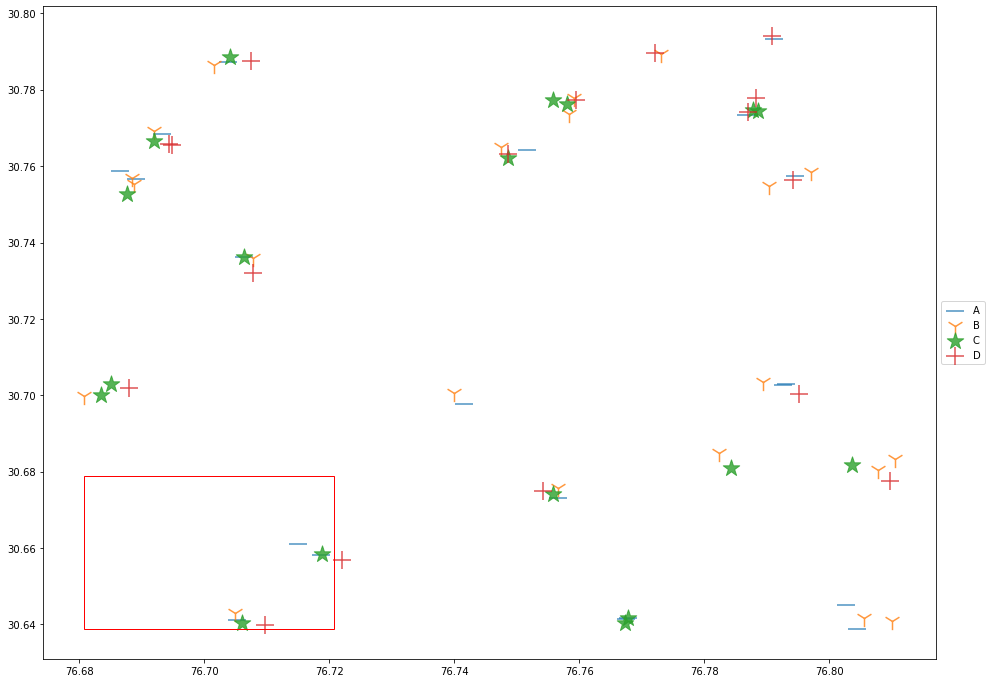

In [27]:
show_rect(lst_of_points, 76.68069457895719, 30.638770989969345, 76.7206945789572, 30.678770989969344)